## Tracking activity on Companies House

In [1]:
import os, json
import matplotlib.pyplot as plt
from raphtory import Graph
from datetime import datetime
from raphtory import vis

### How to obtain the data

The Companies House data can be obtained via their [REST API](https://developer.company-information.service.gov.uk/overview). For this example to work, you will need to use our Companies House scraper. The scraper can be pulled from this [repo](https://github.com/Pometry/companies_house_scraper). We have prepped a crawler specifically for this example in the file `docbrownexample.py`. All you will need to do is enter your Companies House REST API key which can be obtained from the website via creating a developer account. Follow the README in this repo to make sure you have all the dependencies. Once this is all done, use the command `scrapy crawl barbara` to obtain the desired data.

### Analysing the data with Raphtory

We use the python json library to parse the json files obtained via the crawler. Through this, we can create a Raphtory graph and add our variables to the graph via the `add_edge` function.

In [2]:
# Enter the directory path to your json files inside the path_to_json quotation marks, it should look something like: ~/Pometry/companies_house_scraper/tutorial/data/aqWJlHS4_rJSJ7rLgTK49iO4gAg
path_to_json = ''
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

# Create a Raphtory graph
g = Graph()

# Iterate through all the json files (there are many files since the crawler works by crawling page by page)
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
# Try assigning values to variables. Note that we convert datetime format to epoch timestamps since Raphtory requires time to be in Epoch format.
        try:
            ap_d = datetime.strptime(json_text['items'][0]['appointed_on'], "%Y-%m-%d")
            appointed_on = int(datetime.timestamp(ap_d))
            re_d =  datetime.strptime(json_text['items'][0]['resigned_on'], "%Y-%m-%d")
            resigned_on = int(datetime.timestamp(re_d))
            company_name = json_text['items'][0]['appointed_to']['company_name']
            director_name = json_text['items'][0]['name']
# Create an edge with time director was appointed to this company, source node is the director name and target node is the company name. The date the director resigned on is set as a property.
            g.add_edge(appointed_on, director_name, company_name, {'resigned_on': resigned_on})
# Catch any missing values in the json files (could be because the director has not resigned at this company yet.)
        except KeyError as e:
            print(f"key {e} not found in json block")


key 'resigned_on' not found in json block
key 'resigned_on' not found in json block
key 'resigned_on' not found in json block
key 'resigned_on' not found in json block
key 'resigned_on' not found in json block
key 'resigned_on' not found in json block
key 'resigned_on' not found in json block
key 'resigned_on' not found in json block
key 'resigned_on' not found in json block


### Finding quick statistics about our data via graphs in Raphtory

With the Raphtory API, we can quickly find stats from our data such as the number of companies the director was assigned to, the earliest/latest date the director was assigned to a company and the earliest/latest date the director resigned from a company.

In [3]:
# Create a list of directors to see how many different names the director goes by
list_of_src= []
for e in g.edges():
   list_of_src.append(e.src().name())
print(f"List of director names: {set(list_of_src)}")

# num_edges() to find the number of companies formed by the director (director -- company edge)
print(f"Number of companies director assigned to: {g.num_edges()}")
# Using python's datetime library to convert epoch back into dates to see what the earliest and latest date the director was assigned to a company.
print(f"Earliest date director was assigned to company: {datetime.fromtimestamp(g.earliest_time())}")
print(f"Latest date director was assigned to company: {datetime.fromtimestamp(g.latest_time())}")

# To obtain the date the director resigned from the company, we have stored this in a property. You can have an infinite number of properties on edges and vertices in Raphtory to store extra information.
# Through creating a list of these times, we can see what the earliest and latest resignation that the director made.
list_resigned_on = []
for e in g.edges():
    list_resigned_on.append(e.property("resigned_on"))
list_resigned_on_max = max(list_resigned_on)
list_resigned_on_min = min(list_resigned_on)
print(f"Earliest company resignation date: {datetime.fromtimestamp(list_resigned_on_min)}")
print(f"Latest company resignation date: {datetime.fromtimestamp(list_resigned_on_max)}")

List of director names: {'Barbara Z KAHAN', 'Barbara KAHAN'}
Number of companies director assigned to: 447
Earliest date director was assigned to company: 2008-10-02 00:00:00
Latest date director was assigned to company: 2016-02-15 00:00:00
Earliest company resignation date: 2008-10-02 00:00:00
Latest company resignation date: 2020-07-01 00:00:00


### Finding information about a particular time window of our graph

We can pick a small view of our graph to filter down all the companies this director was assigned to from 2008 to 2015. We do this with the `g.window()` function which takes a start and end time. 

After creating a view, we can see how many companies the director was appointed to by running the `.degree()` functions on our view.

In [4]:
view = g.window(1400000000, 1450000000)
print(f"Number of companies assigned in this time window: {view.vertex('Barbara KAHAN').degree()}")

Number of companies assigned in this time window: 104


### Using Raphtory properties to refine our analysis

We filter the edges to only see the companies that this director is assigned to and then resigned to the same day.

In [5]:
sus_companies = []
for edge in view.vertex('Barbara KAHAN').edges():
    if edge.property("resigned_on") == edge.earliest_time():
       sus_companies.append(edge)
print(sus_companies.__len__())

88


### Creating perspectives in Raphtory to create a line plot over time

We can use `Perspective` which is a struct representing a time range from `start` to `end`. We use `.rolling()` with a window size of 10000000. This window moves forward by a step size (which is the window if you have not specified a step size). 

Through these methods, we "roll" through all the windows/views, counting the number of companies the director was assigned to, and we end up with a line plot of how many companies this director is assigned to over time.

<Axes: xlabel='Time', ylabel='Companies Created'>

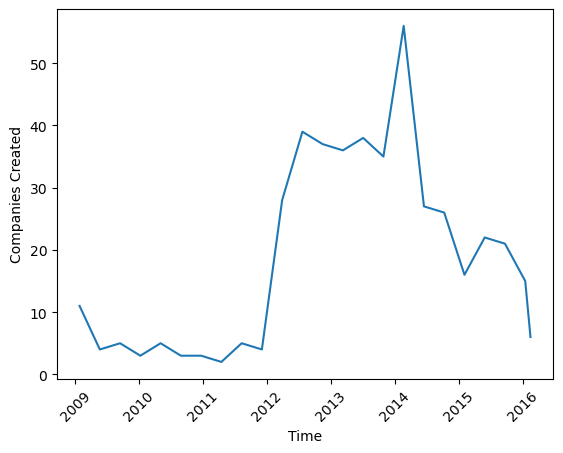

In [6]:
from raphtory import Perspective
import seaborn as sns

# A rolling window of 10000000 moving forward with a step of 10000000.
p = Perspective.rolling(window=10000000) 
views = g.through(p) 
timestamps   = []
edge_count   = []

# For each view, count the number of edges and note the time
for view in views:
    time = datetime.fromtimestamp(view.latest_time())
    timestamps.append(time)
    edge_count.append(view.num_edges())            

# Create the line plot visualisation with seaborn library
sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Companies Created")
sns.lineplot(x = timestamps, y = edge_count,ax=ax)

### Using windows to filter particular timepoints of interest

As seen in the line plot, there is a spike at year 2014. To investigate this further we look at a window of 01-01-2014 to 01-01-2015.

<Axes: xlabel='Time', ylabel='Companies Created'>

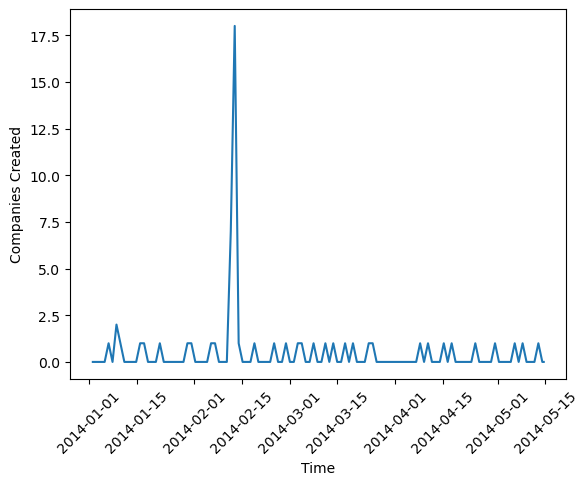

In [7]:
filtered_view = g.window(1388534400, 1400070400)
p = Perspective.rolling(window=100000) 
filtered_views = filtered_view.through(p) 
timestamps   = []
edge_count   = []

for filtered_view in filtered_views:
    time = datetime.fromtimestamp(filtered_view.latest_time())
    timestamps.append(time)
    edge_count.append(filtered_view.num_edges())            

sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Companies Created")
sns.lineplot(x = timestamps, y = edge_count,ax=ax)

There seems to be a spike between 2014-02-01 to 2014-02-15. We create a window for this spike to investigate further.

<Axes: xlabel='Time', ylabel='Companies Created'>

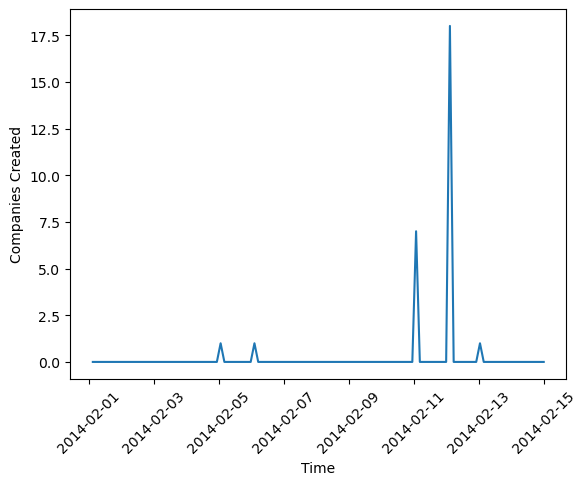

In [8]:
filtered_view2 = g.window(1391212800, 1392422400)
p = Perspective.rolling(window=10000) 
filtered_views2 = filtered_view2.through(p) 
timestamps   = []
edge_count   = []

for filtered_view2 in filtered_views2:
    time = datetime.fromtimestamp(filtered_view2.latest_time())
    timestamps.append(time)
    edge_count.append(filtered_view2.num_edges())            

sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Companies Created")
sns.lineplot(x = timestamps, y = edge_count,ax=ax)

### Dynamic visualisation of your graph in Raphtory

To visualise specific dates, we first create window of the time we want and use Raphtory's `.to_pyvis()` function to create a dynamic visualisation of the edges. In this way, we clearly see the director's company assignation and resignation behaviour.

The visualisation will appear in a file called `nx.html` which can be opened in a web browser.

In [9]:
twelfth_of_feb = g.window(1392163199, 1392163201)
vis.to_pyvis(graph=twelfth_of_feb, edge_color='#F6E1D3',shape="image")  

nx.html


In [10]:
eleventh_of_feb = g.window(1392076799, 1392076801)
vis.to_pyvis(graph=eleventh_of_feb, edge_color='#F6E1D3',shape="image") 

nx.html


If you would like your graph in a list of vertices and edges, you can call methods such as `vertices()` and `edges()`.

In [11]:
eleventh_of_feb.vertices()

Vertices(Vertex(name=Barbara KAHAN, properties={_id : Barbara KAHAN}), Vertex(name=CONPARE LIMITED, properties={_id : CONPARE LIMITED}), Vertex(name=T H HICKS LIMITED, properties={_id : T H HICKS LIMITED}), Vertex(name=BICROWN LIMITED, properties={_id : BICROWN LIMITED}), Vertex(name=X-MAZE IT LTD, properties={_id : X-MAZE IT LTD}), Vertex(name=JOBTION LTD, properties={_id : JOBTION LTD}), Vertex(name=AMERICOURT PROPERTIES LIMITED, properties={_id : AMERICOURT PROPERTIES LIMITED}), Vertex(name=BANXTAN LIMITED, properties={_id : BANXTAN LIMITED}))

In [12]:
eleventh_of_feb.edges()

Edges(Edge(source=Barbara KAHAN, target=CONPARE LIMITED, earliest_time=1392076800, latest_time=1392076800, properties={resigned_on : 1534460400}), Edge(source=Barbara KAHAN, target=T H HICKS LIMITED, earliest_time=1392076800, latest_time=1392076800, properties={resigned_on : 1428447600}), Edge(source=Barbara KAHAN, target=BICROWN LIMITED, earliest_time=1392076800, latest_time=1392076800, properties={resigned_on : 1506034800}), Edge(source=Barbara KAHAN, target=X-MAZE IT LTD, earliest_time=1392076800, latest_time=1392076800, properties={resigned_on : 1422316800}), Edge(source=Barbara KAHAN, target=JOBTION LTD, earliest_time=1392076800, latest_time=1392076800, properties={resigned_on : 1562022000}), Edge(source=Barbara KAHAN, target=AMERICOURT PROPERTIES LIMITED, earliest_time=1392076800, latest_time=1392076800, properties={resigned_on : 1462921200}), Edge(source=Barbara KAHAN, target=BANXTAN LIMITED, earliest_time=1392076800, latest_time=1392076800, properties={resigned_on : 1396393200}